# Lab 7 - Model Deployment
In this lab we'll deploy the financial news sentiment classification network that we built last week so that it's usable via the internet.

The model will be hosted on Microsoft's cloud hosting service _Azure_, where we will run a web server which receives and processes predictions requests over the web via HTTP.

## Mount Your Google Drive Storage

Same as the last lab, we'll be mounting our Google Drive storage for access within this notebook.

Run the next cell and follow the instructions to give Colaboratory access to your Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Once you've authorised Colaboratory, open the Files tab 📁 on the left and navigate to the directory for this lab. Then, right click on it and select "copy path".


<font color="red">In the next cell, paste the path to your directory.</font>

_The path should look like `/content/drive/My_Drive/...`_

In [ ]:
import os
lab_dir = "TODO: PASTE THE COPIED PATH HERE"

# SOLUTION LINE
lab_dir = "/content/drive/My Drive/Work/CSE5DL/labs/lab07"
lab_dir = "/content/drive/My Drive/CSE5DL/lab07"

Now we'll navigate to that directory and print out the files to check that we're in the right place.

<font color="red">Run the next cell and confirm that you see the files you uploaded for this lab.</font>

_If you don't see the lab files, you're in the wrong directory - try finding and copying the path again._

In [ ]:
# Change Python's current working directory
os.chdir(lab_dir)
# Print the name and contents of the current working directory
!pwd
!ls -al

/content/drive/My Drive/CSE5DL/lab07
total 812
-rw------- 1 root root   4196 Jan 12 09:08 index.html
-rw------- 1 root root   2641 Jan 13 03:04 inference.py
-rw------- 1 root root 816448 Feb  2 05:45 lab07.ipynb
drwx------ 2 root root   4096 Feb  3 01:00 model_weights
-rw------- 1 root root    210 Jan 12 02:41 myenv.yml
-rw------- 1 root root     40 Jan 12 09:03 requirements.txt
-rw------- 1 root root   1644 Jan 13 03:03 webserver.py


## Project Structure
You'll notice that although we're using the same model as last lab, the project structure is quite different. We'll learn about the files one at a time as we progress through the lab.

## Register to use Microsoft Azure
As our model will be hosted on the Microsoft Azure Machine Learning service, you will first need to register an account using your La Trobe University credentials.

To begin, visit [portal.azure.com](https://portal.azure.com) and log in using your La Trobe credentials.


## Sign up for a Free Subscription
Before we can use Azure, we first need to sign up for a free subscription.

From [the portal](https://portal.azure.com), click "Subscriptions" to view the subscriptions associated with your account.
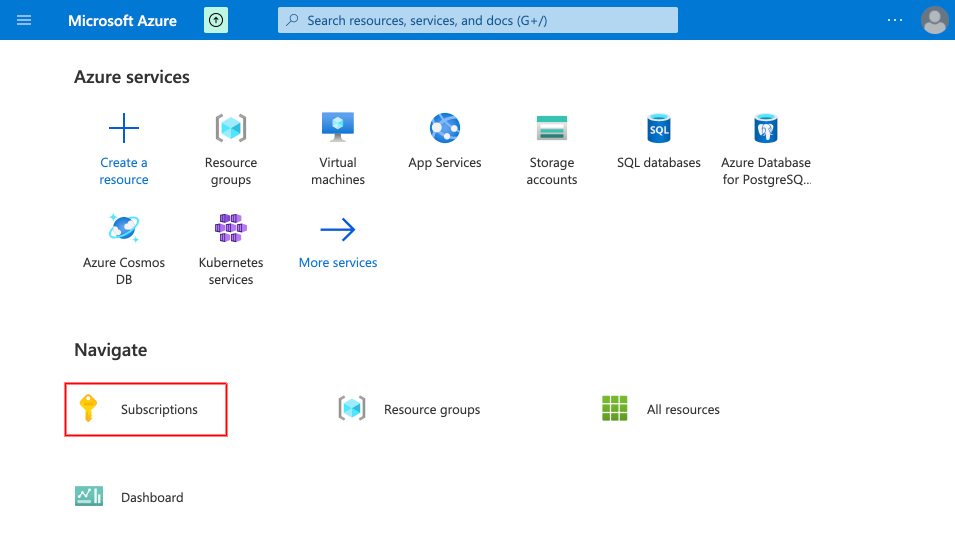

Click on "Add" in the top-left hand corner to add a new subscription.
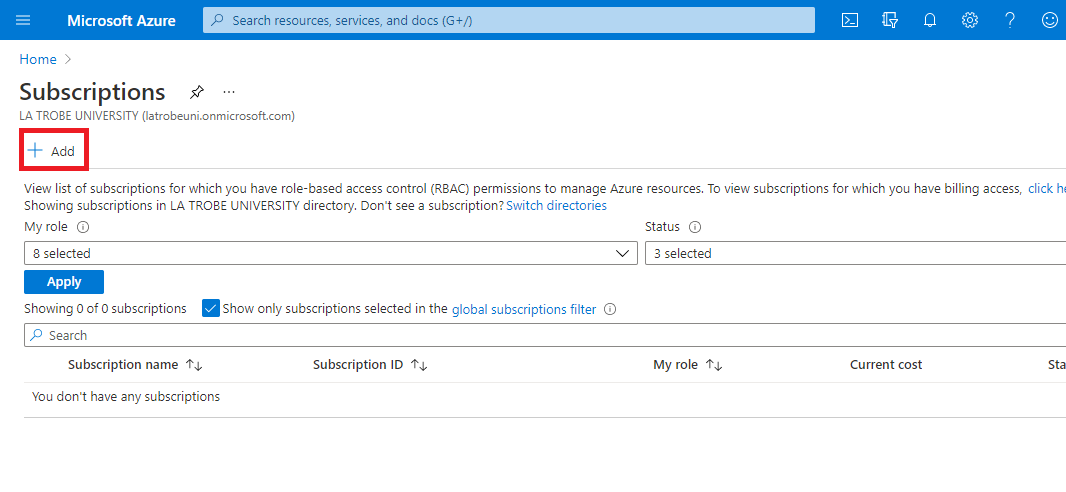

This will direct you to a new page. You may be prompted for your password again.  
Once the new page loads, select the "Azure for Students" subscription.
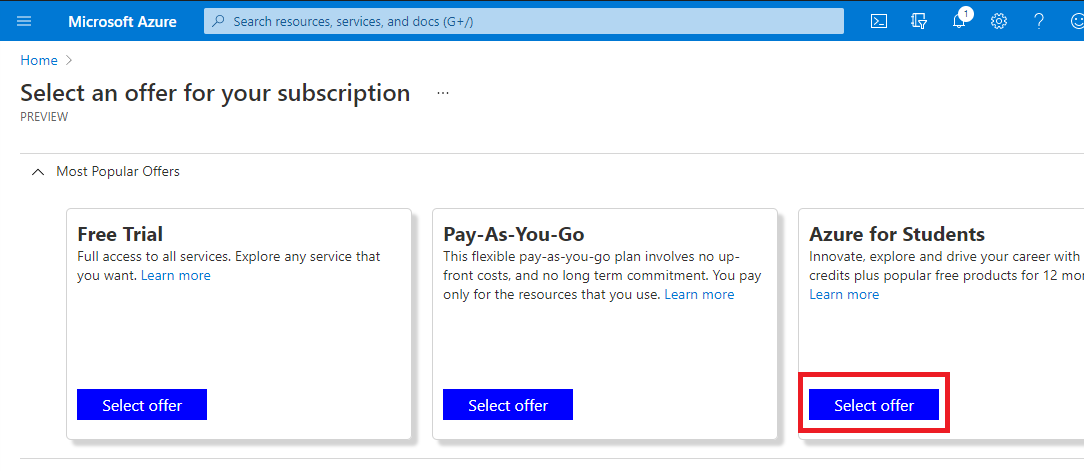

This will take you to a new page again, where you can click on "Start free".
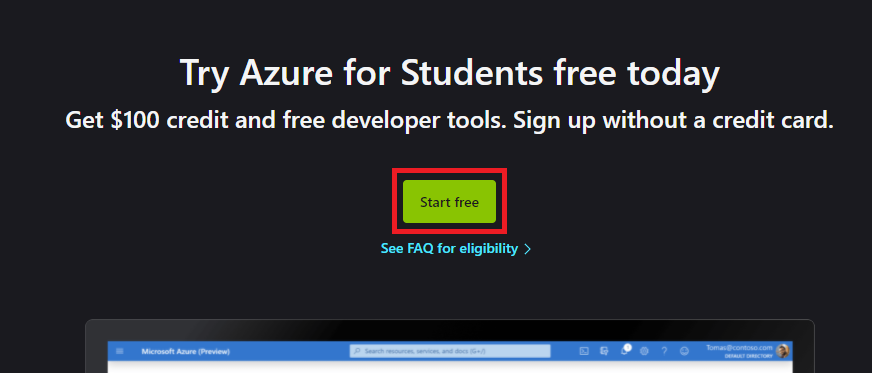

To verify yourself, you will be asked to receive a text message verification.
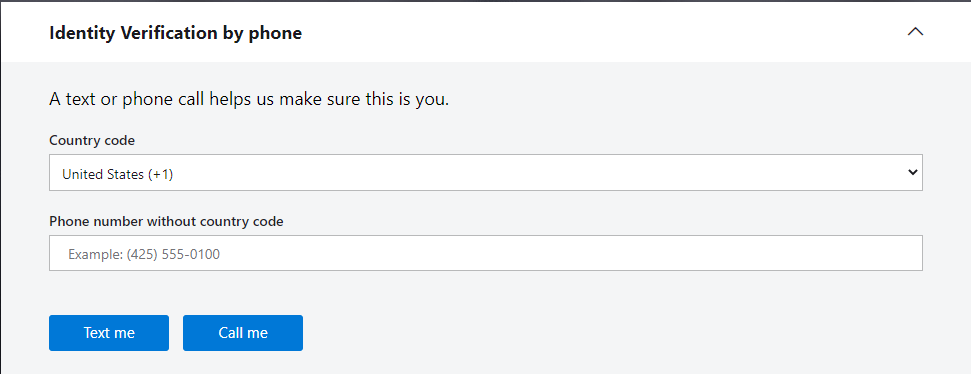

Once verified, you then need to provide your details to sign up for the subscription.5_fill_in_details.png


Once you complete the sign up process you will be redirected to a new page again where you will need to wait a few moments for your subscription to be activated.  
Once activated, proceed to the following section. 

### Copy your Subscription ID
In order to interact with Azure using Python, we need to take note of the subscription ID you're using. From [the portal](https://portal.azure.com), click "Subscriptions" to view the subscriptions assosiated with your account.
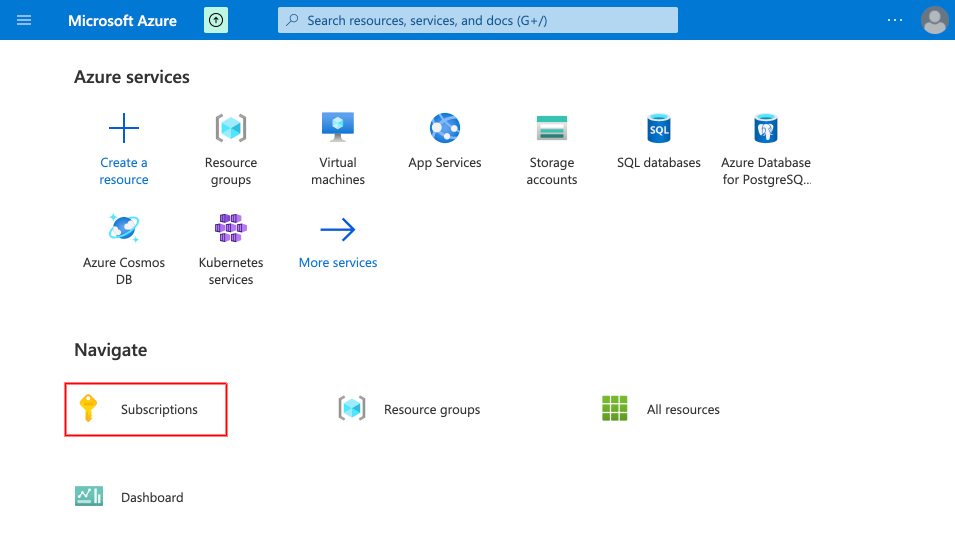

Then, double click to select your subscription ID, then copy it to the clipboard.

_You may have more than one subsription if you've used Azure before. If so, select the subscription that relates to this subject._

1610516651639.png

Paste your subscription ID below.

In [ ]:
SUBSCRIPTION_ID = "TODO: paste your subscription ID here"

# SOLUTION LINE
SUBSCRIPTION_ID = "9146e775-3b90-4cdd-99de-e3271aac0a1b"
SUBSCRIPTION_ID = "59c05698-efd0-4fe5-b186-c3b83cf559da"


### Export model
Although it's possible to do some model deployment via the Azure portal, it's more convenient to use the Python SDK (Software Development Kit), as it's faster and easily reproducible. Thus, we first need to install the Azure SDK using `pip`.

Run the next cell to install two Python libraries locally:
 * `azureml-core`: the SDK for managing machine learning tasks on Azure.
 * `flask-ngrok`: a tool that helps with web-hosting - we'll discuss this a little later.

In [ ]:
!pip install -qr requirements.txt

     |████████████████████████████████| 2.1MB 8.3MB/s 
     |████████████████████████████████| 112kB 46.1MB/s 
     |████████████████████████████████| 153kB 43.8MB/s 
     |████████████████████████████████| 40kB 5.0MB/s 
     |████████████████████████████████| 143kB 39.7MB/s 
     |████████████████████████████████| 61kB 7.4MB/s 
     |████████████████████████████████| 102kB 10.0MB/s 
     |████████████████████████████████| 92kB 9.3MB/s 
     |████████████████████████████████| 92kB 9.8MB/s 
     |████████████████████████████████| 552kB 41.5MB/s 
     |████████████████████████████████| 727kB 52.6MB/s 
     |████████████████████████████████| 61kB 7.9MB/s 
     |████████████████████████████████| 1.1MB 40.4MB/s 
     |████████████████████████████████| 2.6MB 48.8MB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
     |████████████████████████████████| 552kB 62.4MB/s 
     |████████████████████████████████| 204kB 47.8MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 


With the Azure SDK installed, we have the ability to provision compute resources and manage machine learning tasks - all in Python.

### Create a Workspace
A workspace is a top-level container for Azure machine learning projects. It houses models, services, scripts, and much more. The first step is therefore to create a workspace for this project.

A workspace must belong to a "resource group", which is a container for resources that don't necessarily relate to machine learning. A resource group will be automatically created for us when we create a workspace, so we don't need to be too concerned with it.

<font color="red">Run the next cell to create a workspace and its containing resource group. Follow the instructions presented to copy and paste an authorisation code in another tab, and log in with your student account.</font>

_This operation may take a few minutes, so be patient._

In [ ]:
from azureml.core import Workspace

try:
    # Try to get the workspace in case it was previously created
    workspace = Workspace.get(
        name='cse5dl-lab07',
        subscription_id=SUBSCRIPTION_ID,
        resource_group='cse5dl')
except:
    # If that fails, create the workspace
    workspace = Workspace.create(
        name='cse5dl-lab07',
        subscription_id=SUBSCRIPTION_ID,
        resource_group='cse5dl',
        create_resource_group=True,
        location='eastus2')

Performing interactive authentication. Please follow the instructions on the terminal.
To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code EZ5F9QB8W to authenticate.
You have logged in. Now let us find all the subscriptions to which you have access...


Failed to authenticate to tenant '8d2e0f4c-55f2-4cb1-8ee7-da5dd3ff3600' due to error 'Get Token request returned http error: 400 and server response: {"error":"interaction_required","error_description":"AADSTS50079: Due to a configuration change made by your administrator, or because you moved to a new location, you must enroll in multi-factor authentication to access '797f4846-ba00-4fd7-ba43-dac1f8f63013'.\r\nTrace ID: f51ca09e-0ff9-47c5-a766-012e433d0800\r\nCorrelation ID: 517d55d7-1a37-421d-895e-ff9b85af51e6\r\nTimestamp: 2021-02-03 01:16:28Z","error_codes":[50079],"timestamp":"2021-02-03 01:16:28Z","trace_id":"f51ca09e-0ff9-47c5-a766-012e433d0800","correlation_id":"517d55d7-1a37-421d-895e-ff9b85af51e6","error_uri":"https://login.microsoftonline.com/error?code=50079","suberror":"basic_action"}'.Will continue to look for other tenants to find subscriptions to which you have access


Interactive authentication successfully completed.


get_workspace error using subscription_id=59c05698-efd0-4fe5-b186-c3b83cf559da, resource_group_name=cse5dl, workspace_name=cse5dl-lab07


Deploying StorageAccount with name cse5dllastorage0907ee496.
Deploying AppInsights with name cse5dllainsights50ac23a8.
Deployed AppInsights with name cse5dllainsights50ac23a8. Took 78.1 seconds.
Deploying KeyVault with name cse5dllakeyvaultd8f664c5.
Deployed KeyVault with name cse5dllakeyvaultd8f664c5. Took 90.76 seconds.
Deployed StorageAccount with name cse5dllastorage0907ee496. Took 90.51 seconds.
Deploying Workspace with name cse5dl-lab07.
Deployed Workspace with name cse5dl-lab07. Took 87.46 seconds.


### Register the Model
The last lab finished with a transformer network trained for sentiment classification. To begin, copy the saved weights file (`transformer.pth`) into this lab's `model_weights` directory. This can be done using the regular Google Drive [web interface](https://drive.google.com/drive/my-drive).

_If you don't have the weights from last lab, you can download a copy [here](https://drive.google.com/file/d/126mixtlOO7K3SkPc_LfUTyy11wvB6yUF/view?usp=sharing)._

Once that's done, we need to register the model with Azure. In doing so, a copy of the model weights is uploaded and tagged. Azure allows for versioning model weights, but that's beyond the scope of this lab.

<font color="red">Run the next cell to register the model in your workspace. This may take a few minutes depending on internet speed.</font>

In [ ]:
from azureml.core.model import Model

try:
    # Try to get the model from the workspace in case it was already registered
    model = Model.list(workspace=workspace)[-1]
except:
    # If that fails, register the model for the first time
    model = Model.register(
        workspace=workspace,
        model_path='./model_weights',
        model_name='news-sentiment-classifier',
        description='Natural language sentiment classification model trained on financial news titles')

Registering model news-sentiment-classifier


### Inference Configuration
The server will process requests in whichever manner we desire, so it's up to us to describe how the server works; this is done with an `InferenceConfig`.

You'll notice in the next cell that we refer to two files: `inference.py` and `myenv.yml`. Read the descriptions below, then open each of the files using the files tab on the left, and read through them.

__inference.py__ \
This script is the minimal instructions required for making predictions with our model. Azure requires that it have two functions:
 * `init`: This function is called when the server is started, and should prepare the model for inference.
 * `run`: This function is called when any requests are received, and is to return the model's prediction given the inputs.

Usage is something like this:
```python
import inference
inference.init()
inference.run('Stock market good')
inference.run('Stock market bad')
...
```

__myenv.yml__ \
This is a [Conda](https://docs.conda.io/) configuration file which is used to describe our project dependencies. When we provision our resources, a [Docker](https://www.docker.com/) image is created and our dependencies installed. You'll notice that we have only a few dependencies as it's what's required for performing model inference and nothing more.

<font color="red">Run the next cell to create the inference configuration</font>

In [ ]:
from azureml.core.model import InferenceConfig

# Combine scoring script and environment in inference configuration
inference_config = InferenceConfig(
    runtime='python',
    entry_script='inference.py',
    conda_file='myenv.yml'
)

### Webservice Configuration
Now we just need to describe our compute resources. We don't require much capacity, so we'll just allocate a single core machine with 2GB of memory.

<font color="red">Run the next cell to create the webservice configuration.</font>

In [ ]:
from azureml.core.webservice import AciWebservice

# Set deployment configuration
deployment_config = AciWebservice.deploy_configuration(cpu_cores=1, memory_gb=2)

### Deploy the Model
All that's left is to deploy the model - this is what actually triggers the provisioning of all resources, so may take up to 15 minutes to complete. You can read ahead while you wait for it to complete.

<font color="red">Run the below cell to provision resources and deploy the model.</font>

In [ ]:
# This call triggers deployment but doesn't wait for it to finalise
service = Model.deploy(
    workspace=workspace,
    name="sentiment",
    models=[model],
    inference_config=inference_config,
    deployment_config=deployment_config,
    overwrite=True)

# Wait for deployment to complete
service.wait_for_deployment()

ACI service creation operation finished, operation "Succeeded"


If the previous cell has finished running and there were no errors - the web service is live! To see its web address, run the below cell. You'll see a path which ends with `/score` - this is where prediction requests should be sent.

In [ ]:
print(service.scoring_uri)

http://5bd3d5a4-5e2b-4c03-b523-47930ea03b3f.eastus2.azurecontainer.io/score


### Test the Endpoint
With the server running, we can make a HTTP request and check that the response is what we expect. If you visit the link, you should consistently see a web page which says "Positive" or "Negative" - this is what happens when the model is fed an empty string as input.

Visiting a web page performs a GET request; in order to pass a string to the model, we need to perform a POST request - which will require a little code.

<font color="red">Run the below cell to perform inference using your remote machine learning model.</font>

In [ ]:
import requests
import json

def predict(input_str):
    # Make a post request at our specified URI with the input string
    resp = requests.post(url=service.scoring_uri,
                         json=input_str)
    # Decode the response from json to a regular string
    sentiment = resp.json()
    return sentiment

print(predict("Dow Jones plummets two points amid union strikes"))
print(predict("Market improves for third day in a row"))

Negative
Positive


### Starting a Web Server
You now have a functional model accessible via the web - great!

To make the prediction process a little nicer, we're going to start a basic web server. This will serve a single HTML file with an interface for making model predictions.

Typically we would just start the server and visit our local IP address, but we don't get access to that when using Colaboratory. This is where `flask-ngrok` (that we installed earlier) comes in handy. Ngrok provides a public URL which forwards requests for us, meaning we can access the web server without knowing our own IP address.

This has all been taken care of inside `webserver.py`. Before running the next cell, open this file and read through it. The comments should be quite helpful.

<font color="red">Run the next cell to start the interface web server. Once it's started, visit the `http://XXX.ngrok.io` address printed below.</font>

In [ ]:
import webserver
webserver.start(service.scoring_uri)

 * Serving Flask app "webserver" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://917745d54e83.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [03/Feb/2021 01:49:33] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [03/Feb/2021 01:49:33] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [03/Feb/2021 01:50:10] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [03/Feb/2021 01:50:26] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [03/Feb/2021 01:50:40] "POST /predict HTTP/1.1" 200 -


### Clean Up
__Important:__ After trying out the model a few times using the web interface, it's time to shut down and deprovision our resources. If you don't do this, you will use up your free credits.


We'll do this via the Azure web interface, so visit [the portal](https://portal.azure.com), and click on "Resource Groups" - next to the subscriptions button you clicked earlier. There, you should find your cse5dl resource group - click on that to enter it.

1610575689581.png

To the bottom right of this screen you'll see a list of resources, including a Container Registry and Machine Learning.

A Docker image was built during deployment, so we could pull that image from Container Registry and use it locally if we desired. This is outside the scope of this lab, but feel free to look around if you're interested.

Before we clean up, we will have a look at the Machine Learning space. Click the name of the Machine Learning space to open it.

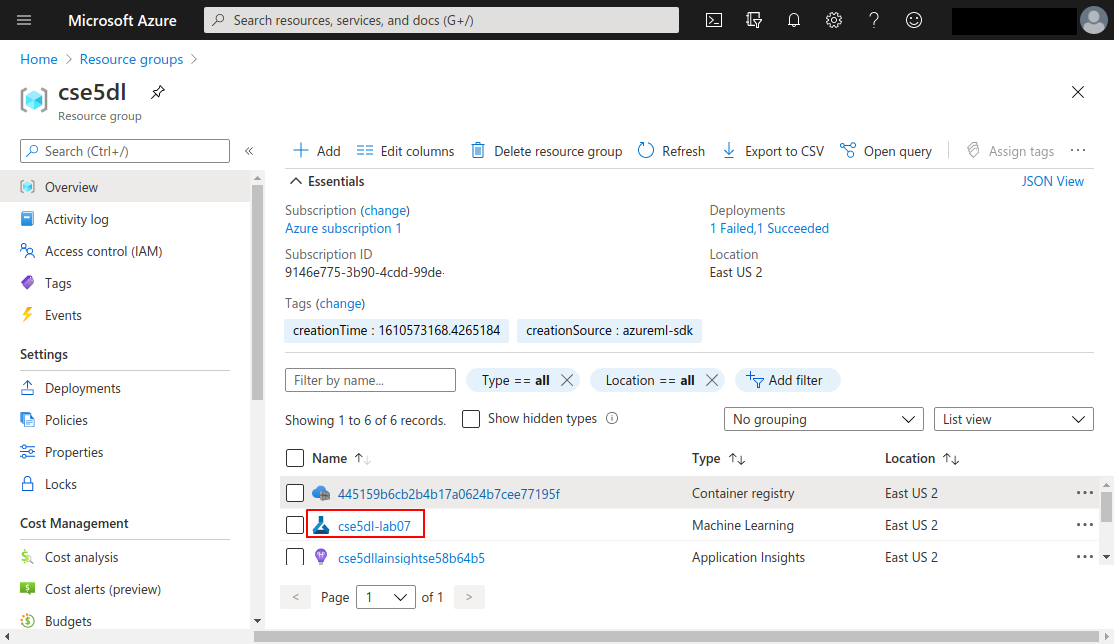

The page we're presented with contains metadata about our Machine Learning resource; click the "Studio web URL" on the top right to visit the studio.

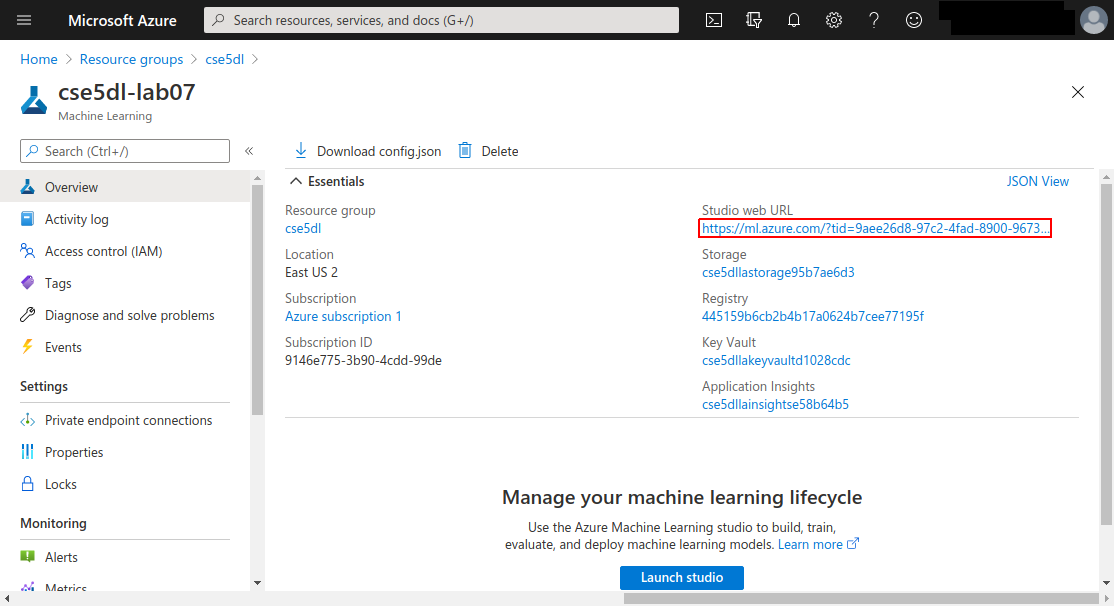

Take a few minutes to look around the interface, as is this is where we would house all of our models, experiment information and datasets - you can even run Notebooks using our provisioned resources!

Click on the models and endpoints tabs on the left to see the resources we created. Then, return to the cse5dl resource group using the same instructions as before.

Time to finally delete the resource group and all of its contained resources. Although we can delete the resources individually, we'll delete everything in one step. Click the "Delete resource group" button to open the confirmation dialog.

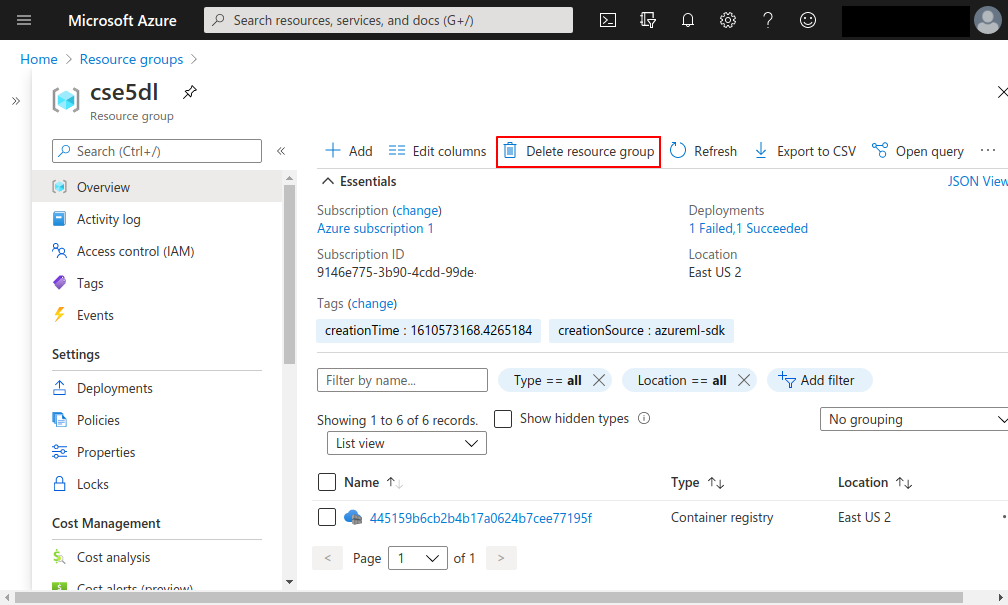

To confirm and begin deletion, type the name of the resource group "cse5dl" into the text box and click "delete". This will take a few minutes to process, so it's best wait until you're given confirmation before exiting.

image.png

After confirmation, click the person icon on the top right and click "Sign out".

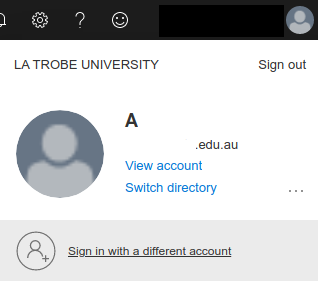

That's it! You've successfully provisioned resources and started a machine learning prediction server, then shut down and deprovisioned again like you were never there. Although it's a slow process, it's much faster than managing your own servers, and Azure provides advanced mechanisms (which we won't explore here) to automatically scale resources based on demand.